In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/n/home12/binxuwang/Github/Neuro-ActMax-GAN-comparison")
from core.utils.plot_utils import saveallforms
from insilico_analysis.insilico_analysis_lib import sweep_dir

In [2]:
""" Cluster version of BigGAN Evol """
import re
import glob
import os
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from tqdm import tqdm, trange
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pylab as plt
import seaborn as sns
import torch
import torch.nn.functional as F
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from pytorch_pretrained_biggan import (BigGAN, truncated_noise_sample, one_hot_from_names, save_as_images)
from core.utils.CNN_scorers import TorchScorer
from core.utils.GAN_utils import BigGAN_wrapper, upconvGAN, loadBigGAN
from core.utils.grad_RF_estim import grad_RF_estimate, gradmap2RF_square
from core.utils.layer_hook_utils import get_module_names, layername_dict, register_hook_by_module_names, get_module_name_shapes
from core.utils.Optimizers import CholeskyCMAES, HessCMAES, ZOHA_Sphere_lr_euclid
import scipy.stats as stats
from scipy.stats import sem
from core.utils.stats_utils import shaded_errorbar

def group_stats_by_gen(generations, value, funcs=[np.mean, sem]):
    gen_slice = np.arange(min(generations), max(generations) + 1)
    mean_score = np.zeros((gen_slice.shape[0], value.shape[1]))
    sem_score = np.zeros((gen_slice.shape[0], value.shape[1]))
    max_score = np.zeros((gen_slice.shape[0], value.shape[1]))
    for i, geni in enumerate(gen_slice):
        mean_score[i, :] = np.mean(value[generations == geni], axis=0)
        sem_score[i, :] = sem(value[generations == geni], axis=0)
        max_score[i, :] = np.max(value[generations == geni])
    return gen_slice, mean_score, sem_score, max_score



In [5]:
figdir = r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/BigGAN_Project/CCN_dynamics_figs"

In [6]:
LRMroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/Projects/Evol_lrm_GAN_cmp"
# LRMroot = "/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/Evol_lrm_GAN_cmp/" #synopsis/alexnet_lrm3_df_img.pkl
# df_lrm3 = pd.read_pickle(join(LRMroot, "synopsis", "alexnet_lrm3_df_img.pkl"))
saveroot = LRMroot
syndir = join(r"/n/holylabs/LABS/kempner_fellows/Users/binxuwang/Projects/Evol_lrm_GAN_cmp", "synopsis")
os.makedirs(syndir, exist_ok=True)

In [46]:
!ls {LRMroot}

alexnet_lrm1-fc7_relu-Ch0000
alexnet_lrm1-fc7_relu-Ch0001
alexnet_lrm1-fc7_relu-Ch0002
alexnet_lrm1-fc7_relu-Ch0003
alexnet_lrm1-fc7_relu-Ch0004
alexnet_lrm1-fc7_relu-Ch0005
alexnet_lrm1-fc7_relu-Ch0006
alexnet_lrm1-fc7_relu-Ch0007
alexnet_lrm1-fc7_relu-Ch0008
alexnet_lrm1-fc7_relu-Ch0009
alexnet_lrm1-fc7_relu-Ch0010
alexnet_lrm1-fc7_relu-Ch0011
alexnet_lrm1-fc7_relu-Ch0012
alexnet_lrm1-fc7_relu-Ch0013
alexnet_lrm1-fc7_relu-Ch0014
alexnet_lrm1-fc7_relu-Ch0015
alexnet_lrm1-fc7_relu-Ch0016
alexnet_lrm1-fc7_relu-Ch0017
alexnet_lrm1-fc7_relu-Ch0018
alexnet_lrm1-fc7_relu-Ch0019
alexnet_lrm1-fc7_relu-Ch0020
alexnet_lrm1-fc7_relu-Ch0021
alexnet_lrm1-fc7_relu-Ch0022
alexnet_lrm1-fc7_relu-Ch0023
alexnet_lrm1-fc7_relu-Ch0024
alexnet_lrm2-fc6_relu-Ch0000
alexnet_lrm2-fc6_relu-Ch0001
alexnet_lrm2-fc6_relu-Ch0002
alexnet_lrm2-fc6_relu-Ch0003
alexnet_lrm2-fc6_relu-Ch0004
alexnet_lrm2-fc6_relu-Ch0005
alexnet_lrm2-fc6_relu-Ch0006
alexnet_lrm2-fc6_relu-Ch0007
alexnet_lrm2-fc6_relu-Ch0008
alexnet_lrm2-f

### LRM3 window

In [7]:
df_col = []
# "conv1_relu","conv2_relu","conv3_relu",
for layerkey in ["conv1_relu","conv2_relu","conv3_relu","conv4_relu","conv5_relu","fc6_relu","fc7_relu", "fc8"]:
    for iChannel in trange(25): #range(25):
        if layerkey in ["conv1_relu","conv2_relu","conv3_relu",]:
            savedir = join(saveroot, f"alexnet_lrm3-{layerkey}-Ch{iChannel:04d}_wdw_RFrsz")
        else:
            savedir = join(saveroot, f"alexnet_lrm3-{layerkey}-Ch{iChannel:04d}_wdw")
        jpgfiles = glob.glob(join(savedir, "besteachgen*.jpg"))
        # for iT in [0, 1, 2, 3]:
        for GANname in ["BigGAN", "fc6", ]:
            methodlab = f"{GANname}_CMAES_wdwT0-T3"
            # search for files with the naming "scores%s_%05d.npz" % (methodlab, RND)
            pattern = re.compile(r"besteachgen%s_(\d+).jpg" % (methodlab,))
            jpgfile_GAN = [f for f in jpgfiles if pattern.search(f)]
            for jpgfile in jpgfile_GAN:
                RND = int(pattern.search(jpgfile).group(1))
                title_str = f"alexnet_lrm3 {layerkey} Ch{iChannel} {methodlab} RND {RND}"
                # mtg = plt.imread(jpgfile)
                # finalimg = crop_from_montage(mtg, -1)
                npzfile = join(savedir, f"scores{methodlab}_{RND:05d}.npz")
                data = np.load(npzfile)
                generations = data["generations"]
                scores_all = data["scores_all"]
                scores_dyn_all = data["scores_dyn_all"]
                gen_slice, mean_score, sem_score, max_score = group_stats_by_gen(generations, scores_dyn_all)
                finalscore_dyn = mean_score[-1, :]
                df_col.append({"layerkey": layerkey, "iChannel": iChannel, "Tbeg": 0, "Tedn": 3, "GANname": GANname,
                            "methodlab": methodlab, "RND": RND, 
                            "gen_slice": gen_slice, "mean_score": mean_score, "sem_score": sem_score, "max_score": max_score,
                            "finalscore_dyn": finalscore_dyn, })
                    # "finalimg": finalimg, 
df_img = pd.DataFrame(df_col)
df_img.to_pickle(join(syndir, "df_img_wdw.pkl"))

  0%|                                                                                                                                           | 0/25 [00:00<?, ?it/s]/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/n/home12/binxuwang/.conda/envs/torch/lib/python3.10/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:13<00:00,  1.85it/s]


In [9]:
df_img.rename(columns={"layerkey": "layer"}, inplace=True)
df_img["finalscore_avg"] = df_img["finalscore_dyn"].apply(lambda x: np.mean(x))
df_lrm3  = df_img

In [51]:
df_img["finalscore_dyn"]

0       [10.840324401855469, 4.892007350921631, 6.4521...
1       [17.4198055267334, 8.09208869934082, 10.476771...
2       [9.354552268981934, 4.920060157775879, 6.34278...
3       [6.5695390701293945, 3.8611769676208496, 4.615...
4       [16.695331573486328, 7.540642738342285, 10.153...
                              ...                        
3995    [13.643359184265137, 14.582433700561523, 14.21...
3996    [14.222857475280762, 15.179510116577148, 14.70...
3997    [14.490495681762695, 16.471284866333008, 15.98...
3998    [13.986520767211914, 17.929241180419922, 17.44...
3999    [12.420138359069824, 14.16572093963623, 14.092...
Name: finalscore_dyn, Length: 4000, dtype: object

In [52]:
df_img["finalscore_avg"] = df_img["finalscore_dyn"].apply(lambda x: np.mean(x))

layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    # ttest between the final scores of the two methods
    ttest_res = stats.ttest_ind(df_layer[df_layer.GANname == "BigGAN"]["finalscore_avg"], 
                                df_layer[df_layer.GANname == "fc6"]["finalscore_avg"])
    print(f"Layer {layer} ttest: {ttest_res}")

Layer conv1_relu ttest: Ttest_indResult(statistic=-9.586993279995237, pvalue=4.331159566699061e-20)
Layer conv2_relu ttest: Ttest_indResult(statistic=-14.764449269634818, pvalue=3.530302424078236e-41)
Layer conv3_relu ttest: Ttest_indResult(statistic=-25.955242583675748, pvalue=1.4119001413942757e-94)
Layer conv4_relu ttest: Ttest_indResult(statistic=-33.596470720085854, pvalue=4.218097271429676e-130)
Layer conv5_relu ttest: Ttest_indResult(statistic=-25.578386737048696, pvalue=9.119278800460385e-93)
Layer fc6_relu ttest: Ttest_indResult(statistic=-6.124509087465863, pvalue=1.8476593220030188e-09)
Layer fc7_relu ttest: Ttest_indResult(statistic=-2.6642826080618427, pvalue=0.00796546163691642)
Layer fc8 ttest: Ttest_indResult(statistic=-20.625510824576775, pvalue=8.852139845229679e-69)


In [17]:
df_layer['finalscore_dyn'].loc[3001]

array([15.48881531, 17.51728249, 17.33260345, 16.95236588])

In [ ]:
figh, axs = plt.subplots(2, 4, figsize=(15, 6.), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.stripplot(data=df_layer, x='GANname', y='finalscore_avg', hue="GANname", ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.3)
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', order=['fc6', 'BigGAN'], #palette='magma', 
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi > 3:
        ax.set_xlabel('Time Step', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
# saveallforms(figdir, f'AlexNet-LRM3_window_Evol_Scores_{"CholCMA"}_time_traj', figh)

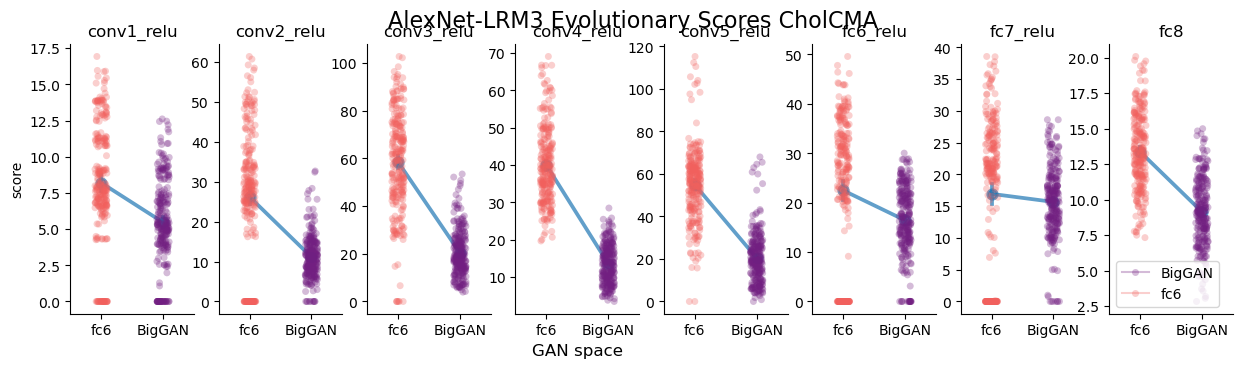

In [10]:
figh, axs = plt.subplots(1, 8, figsize=(15, 3.5), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.stripplot(data=df_layer, x='GANname', y='finalscore_avg', hue="GANname", ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.3)
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', order=['fc6', 'BigGAN'], #palette='magma', 
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi == 3:
        ax.set_xlabel('GAN space', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
saveallforms(figdir, f'AlexNet-LRM3_window_Evol_Scores_{"CholCMA"}_time_traj_linearize', figh)


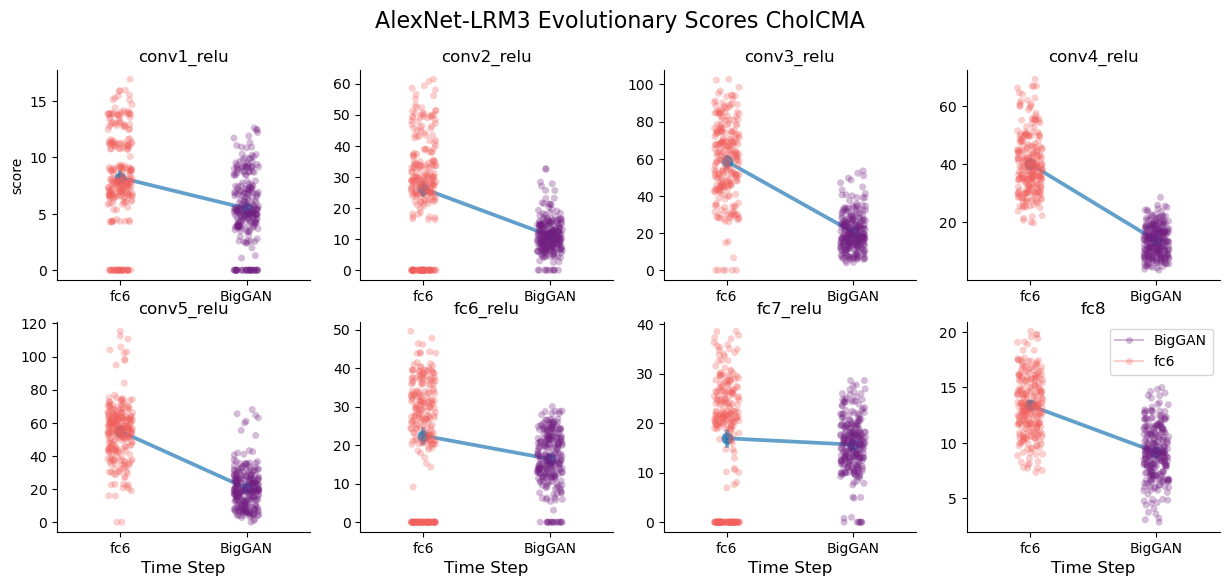

In [53]:
figh, axs = plt.subplots(2, 4, figsize=(15, 6.), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.stripplot(data=df_layer, x='GANname', y='finalscore_avg', hue="GANname", ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.3)
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', order=['fc6', 'BigGAN'], #palette='magma', 
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi > 3:
        ax.set_xlabel('Time Step', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
saveallforms(figdir, f'AlexNet-LRM3_window_Evol_Scores_{"CholCMA"}_time_traj', figh)


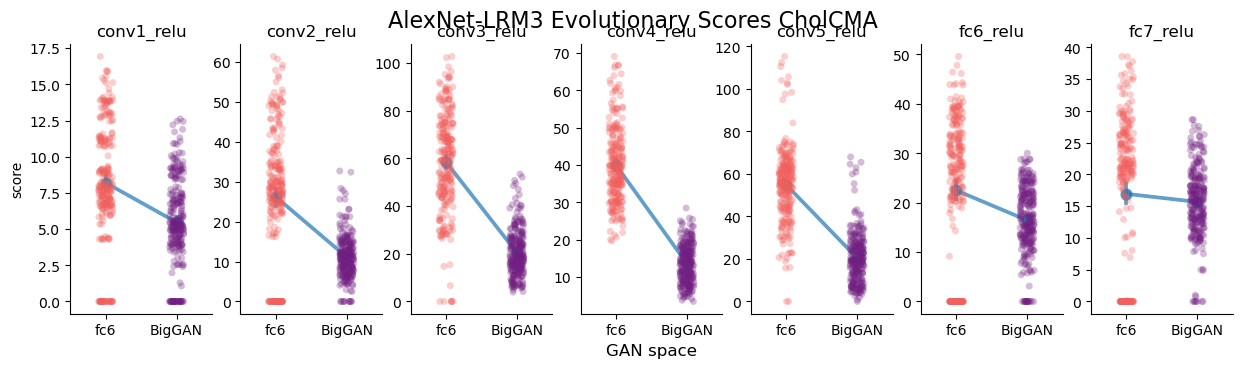

In [11]:
df_lrm3  = df_img
figh, axs = plt.subplots(1, 7, figsize=(15, 3.5), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    if layer == "fc8":
        continue
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.stripplot(data=df_layer, x='GANname', y='finalscore_avg', hue="GANname", ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.3)
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', order=['fc6', 'BigGAN'], #palette='magma', 
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi == 3:
        ax.set_xlabel('GAN space', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
saveallforms(figdir, f'AlexNet-LRM3_window_Evol_Scores_{"CholCMA"}_time_traj_linearize_nofc8', figh)


In [ ]:
df_lrm3  = df_img
figh, axs = plt.subplots(2, 4, figsize=(15, 6.), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.stripplot(data=df_layer, x='GANname', y='finalscore_avg', hue="GANname", ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.3)
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', order=['fc6', 'BigGAN'], #palette='magma', 
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi > 3:
        ax.set_xlabel('Time Step', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
saveallforms(figdir, f'AlexNet-LRM3_window_Evol_Scores_{"CholCMA"}_time_traj', figh)


/tmp/ipykernel_1783558/1791587502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax,
/tmp/ipykernel_1783558/1791587502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax,
/tmp/ipykernel_1783558/1791587502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax,
/tmp/ipykernel_1783558/1791587502.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

Text(0.5, 0.98, 'AlexNet-LRM3 Evolutionary Scores CholCMA')

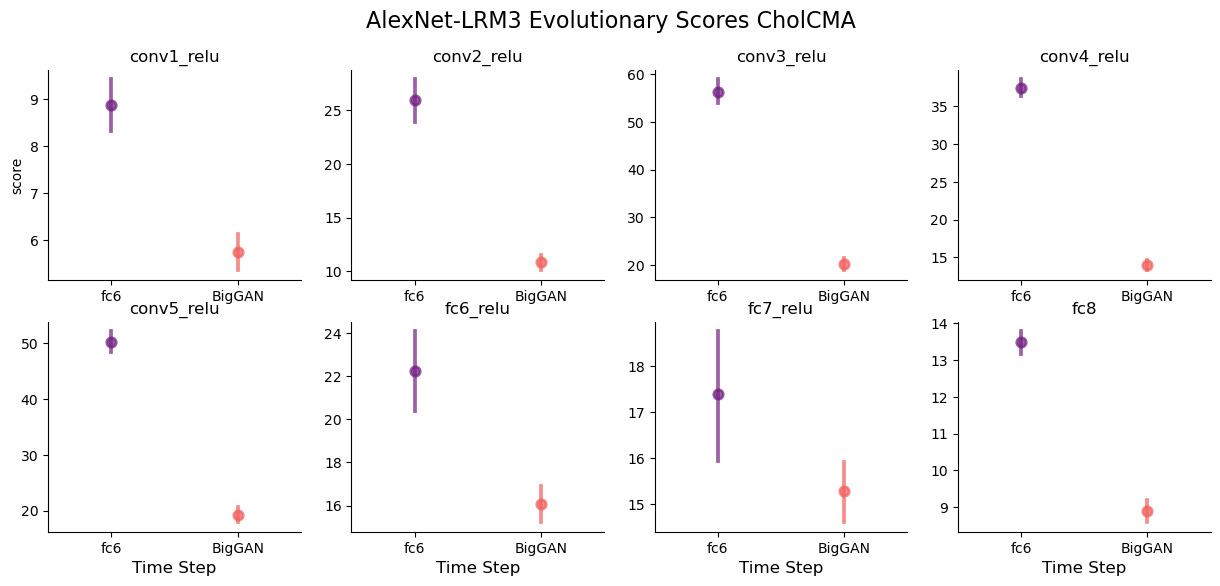

In [30]:
df_lrm3  = df_img
figh, axs = plt.subplots(2, 4, figsize=(15, 6.), sharex=False, sharey=False)
layers = df_lrm3.layer.unique()
for axi, layer in enumerate(layers):
    ax = axs.flatten()[axi]
    df_layer = df_lrm3[(df_lrm3['layer'] == layer)]
    sns.pointplot(data=df_layer, x='GANname', y='finalscore_avg', ax=ax, 
                    linestyles='-', palette='magma', order=['fc6', 'BigGAN'],
                    legend=True if axi == 7 else False, alpha=0.7)
    # ax.plot(df_layer['unitid'], df_layer['score'], 'o', markersize=2)
    ax.set_title(layer, )
    if axi > 3:
        ax.set_xlabel('Time Step', fontsize=12)
    else:
        ax.set_xlabel('')
    if axi == 0:
        ax.set_ylabel('score', )
    else:
        ax.set_ylabel('')
figh.suptitle(f'AlexNet-LRM3 Evolutionary Scores {"CholCMA"}', fontsize=16)
# saveallforms(figdir, f'AlexNet-LRM3_Evol_Scores_{"CholCMA"}_time_traj', figh)


In [25]:
df_img.loc[1001, "finalscore_dyn"]

array([13.32496548, 13.32496548, 18.73803329, 19.44709206, 17.69931602])

In [23]:
df_img.loc[1000, "finalscore_dyn"].shape

(5,)

In [19]:
df_img.shape

(4000, 12)

In [22]:
for id, row in df_img.iterrows():
    assert row["mean_score"].shape == (100, 5)